# Abalone Age Prediction

Abalones are sea snails that are very nutritious and expensive delicacy for their unique taste. Thus, they are in high demand, especially in Asia. This has created a multibillion dollar export industry. There is a positive correlation between the economic value and age of abalone. Thus, determining the age of abalone is an important task because it affects revenue. The traditional approach is time-consuming, and different approaches are needed to speed up the process. The motivation for this project is to address that by determining the age of abalone from physical measurements with machine learning models.

This is a regression type of problem in which a subset of learning algorithms were trained from scikit-learn (k-nearest neighbors, SVR, and random forest), and XGBoost and TabNet regressors. As a single number evaluation metric $R^2$ is used.

The most optimal model is Support Vector Regressor where the evaluation metric for the test data set is $R^2=0.648345$.

Technologies that are used in this project are: scikit-learn, XGBoost, TabNet, Jupyter Notebook.

## Outline

Use these links to jump to specific sections of this project.

* [Problem Statement and Motivation](#chapter1)
* [Import Libraries](#chapter2)
* [Get Data](#chapter3)
* [Data Analysis](#chapter4)
* [Data Preprocessing](#chapter5)
* [Models](#chapter6)
  * [k-Nearest Neighbors](#section6_1)
  * [Support Vector Regressor](#section6_2)
  * [Random Forest](#section6_3)
  * [XGBoost](#section6_4)
  * [TabNet](#section6_5)
* [Model Evaluation](#chapter7)
* [Bibliography](#chapter8)

## Problem Statement and Motivation <a class="anchor" id="chapter1"></a>

Abalones are sea snails that live in kelp forest in ocean water. They are very nutritious, and an expensive delicacy for their unique taste. Consequently, they are in high demand, especially in Asia. This has created a multibillion dollar export industry [1].

There is a positive correlation between the economic value and age of abalone, i.e., the older the abalone the more expensive it is [2]. This makes determining the age of abalone a very important task to those involved in this business. The goal of the project is to determine the age of abalone from physical measurements.

The age of abalone is determined by cutting the shell through the cone, staining it, and counting the number of rings through a microscope, which is a time-consuming task [3]. The motivation of the project is to use morphometric data, i.e., physical measurements of abalone that are much easier to obtain, and use them to predict the age with machine learning models. However, most measurements of size will be highly correlated, so there are few independent variables despite the many measurements [4].

The age of the abalone (in years) is calculated by adding the number of rings with 1.5. Thus, the target is the age of abalone, this is a regression problem.

The following regressors are going to be trained:
- k-Nearest Neighbors regressor,
- Support Vector Regressor,
- Random Forest regressor,
- XGboost regressor, and
- TabNet regressor.

## Import Libraries <a class="anchor" id="chapter2"></a>

In [1]:
import numpy as np
import pandas as pd
from ydata_profiling import ProfileReport
import torch
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
# magic command is required
# via https://github.com/ydataai/pandas-profiling/issues/905#issuecomment-1049036113
%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.pipeline import Pipeline

In [3]:
# Models
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from pytorch_tabnet.tab_model import TabNetRegressor

In [4]:
# metrics
from sklearn.metrics import r2_score, mean_absolute_error
from pytorch_tabnet.metrics import Metric

In [5]:
# turn off warnings completely for the notebook
import warnings
warnings.filterwarnings('ignore')

## Get Data <a class="anchor" id="chapter3"></a>

The data set is obtained from UCI Machine Learning Repository from the following link: http://archive.ics.uci.edu/ml/datasets/Abalone [3].

In [6]:
abalone = pd.read_csv('data/abalone.data.csv', header=None)
abalone.head()

,0,1,2,3,4,5,6,7,8
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [7]:
# The data set doesn't have a header, so we create it.
abalone.columns = ['Sex', 'Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight', 'Viscera weight', 'Shell weight', 'Rings']

In [8]:
# Split dataset to training, validation and testing datasets
train_val, test = train_test_split(abalone, test_size=0.15, random_state=12345)
train, val = train_test_split(train_val, test_size=0.15, random_state=12345)

# Save training dataset
train_val.to_csv('data/train.csv', index=False) # Do not write row names (index).

# Save testing dataset
test.to_csv('data/test.csv', index=False)

In [9]:
# Convert to pandas for further analysis
train = pd.DataFrame(train)
val = pd.DataFrame(val)
test = pd.DataFrame(test)

## Data Analysis <a class="anchor" id="chapter4"></a>

In [10]:
profile = ProfileReport(train, title="Profiling Report")

In [11]:
profile.to_widgets()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

- There are eight (8) features to train the learning algorithms.
- The target is `Rings`.
- There are 4177 examples, which should be enough to train the algorithms.
- There is one categorical feature, `Sex`, and the rest are numerical.
- There aren't any missing values.
- The feature `Height` has a value equal to zero which doesn't make sense. This data point needs to be removed.
- None of the features are normally distributed, but they have one peak.
- The features `Length`, and `Diameter` are left-skewed, and the rest of the features are right-skewed.
- There are gaps in some histograms at the tails of the distributions, because they might be outliers.
- The feature `Height` has outliers.

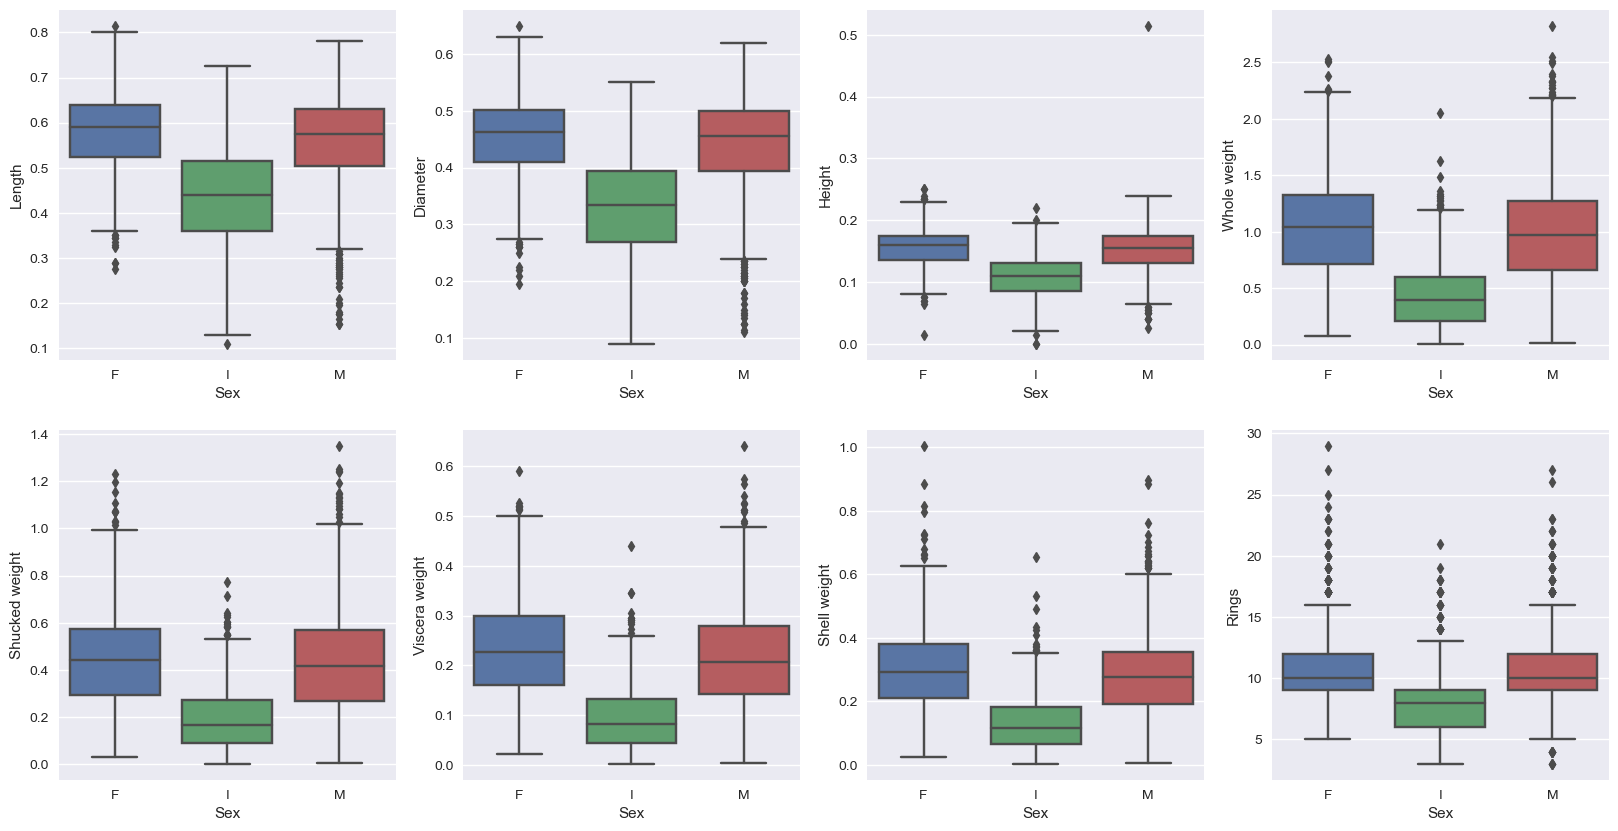

In [12]:
ncols = train.loc[:, train.dtypes != 'object'].shape[1]
fig, axes = plt.subplots(2, 4, figsize=(20,10))

for ax in axes.flatten():
    ax.set_axis_off()
    
for column, ax in zip(train.loc[:, train.dtypes != 'object'].columns, axes.flatten()):
    sns.boxplot(x=train['Sex'], y=train[column], data=train, ax=ax)
    ax.set_axis_on()
    
plt.show()

- It should be expected that the median of each feature versus the sex of the male and female is similar, and they both differ from the infants. In general, the distribution of the numerical features versus the sex is similar.

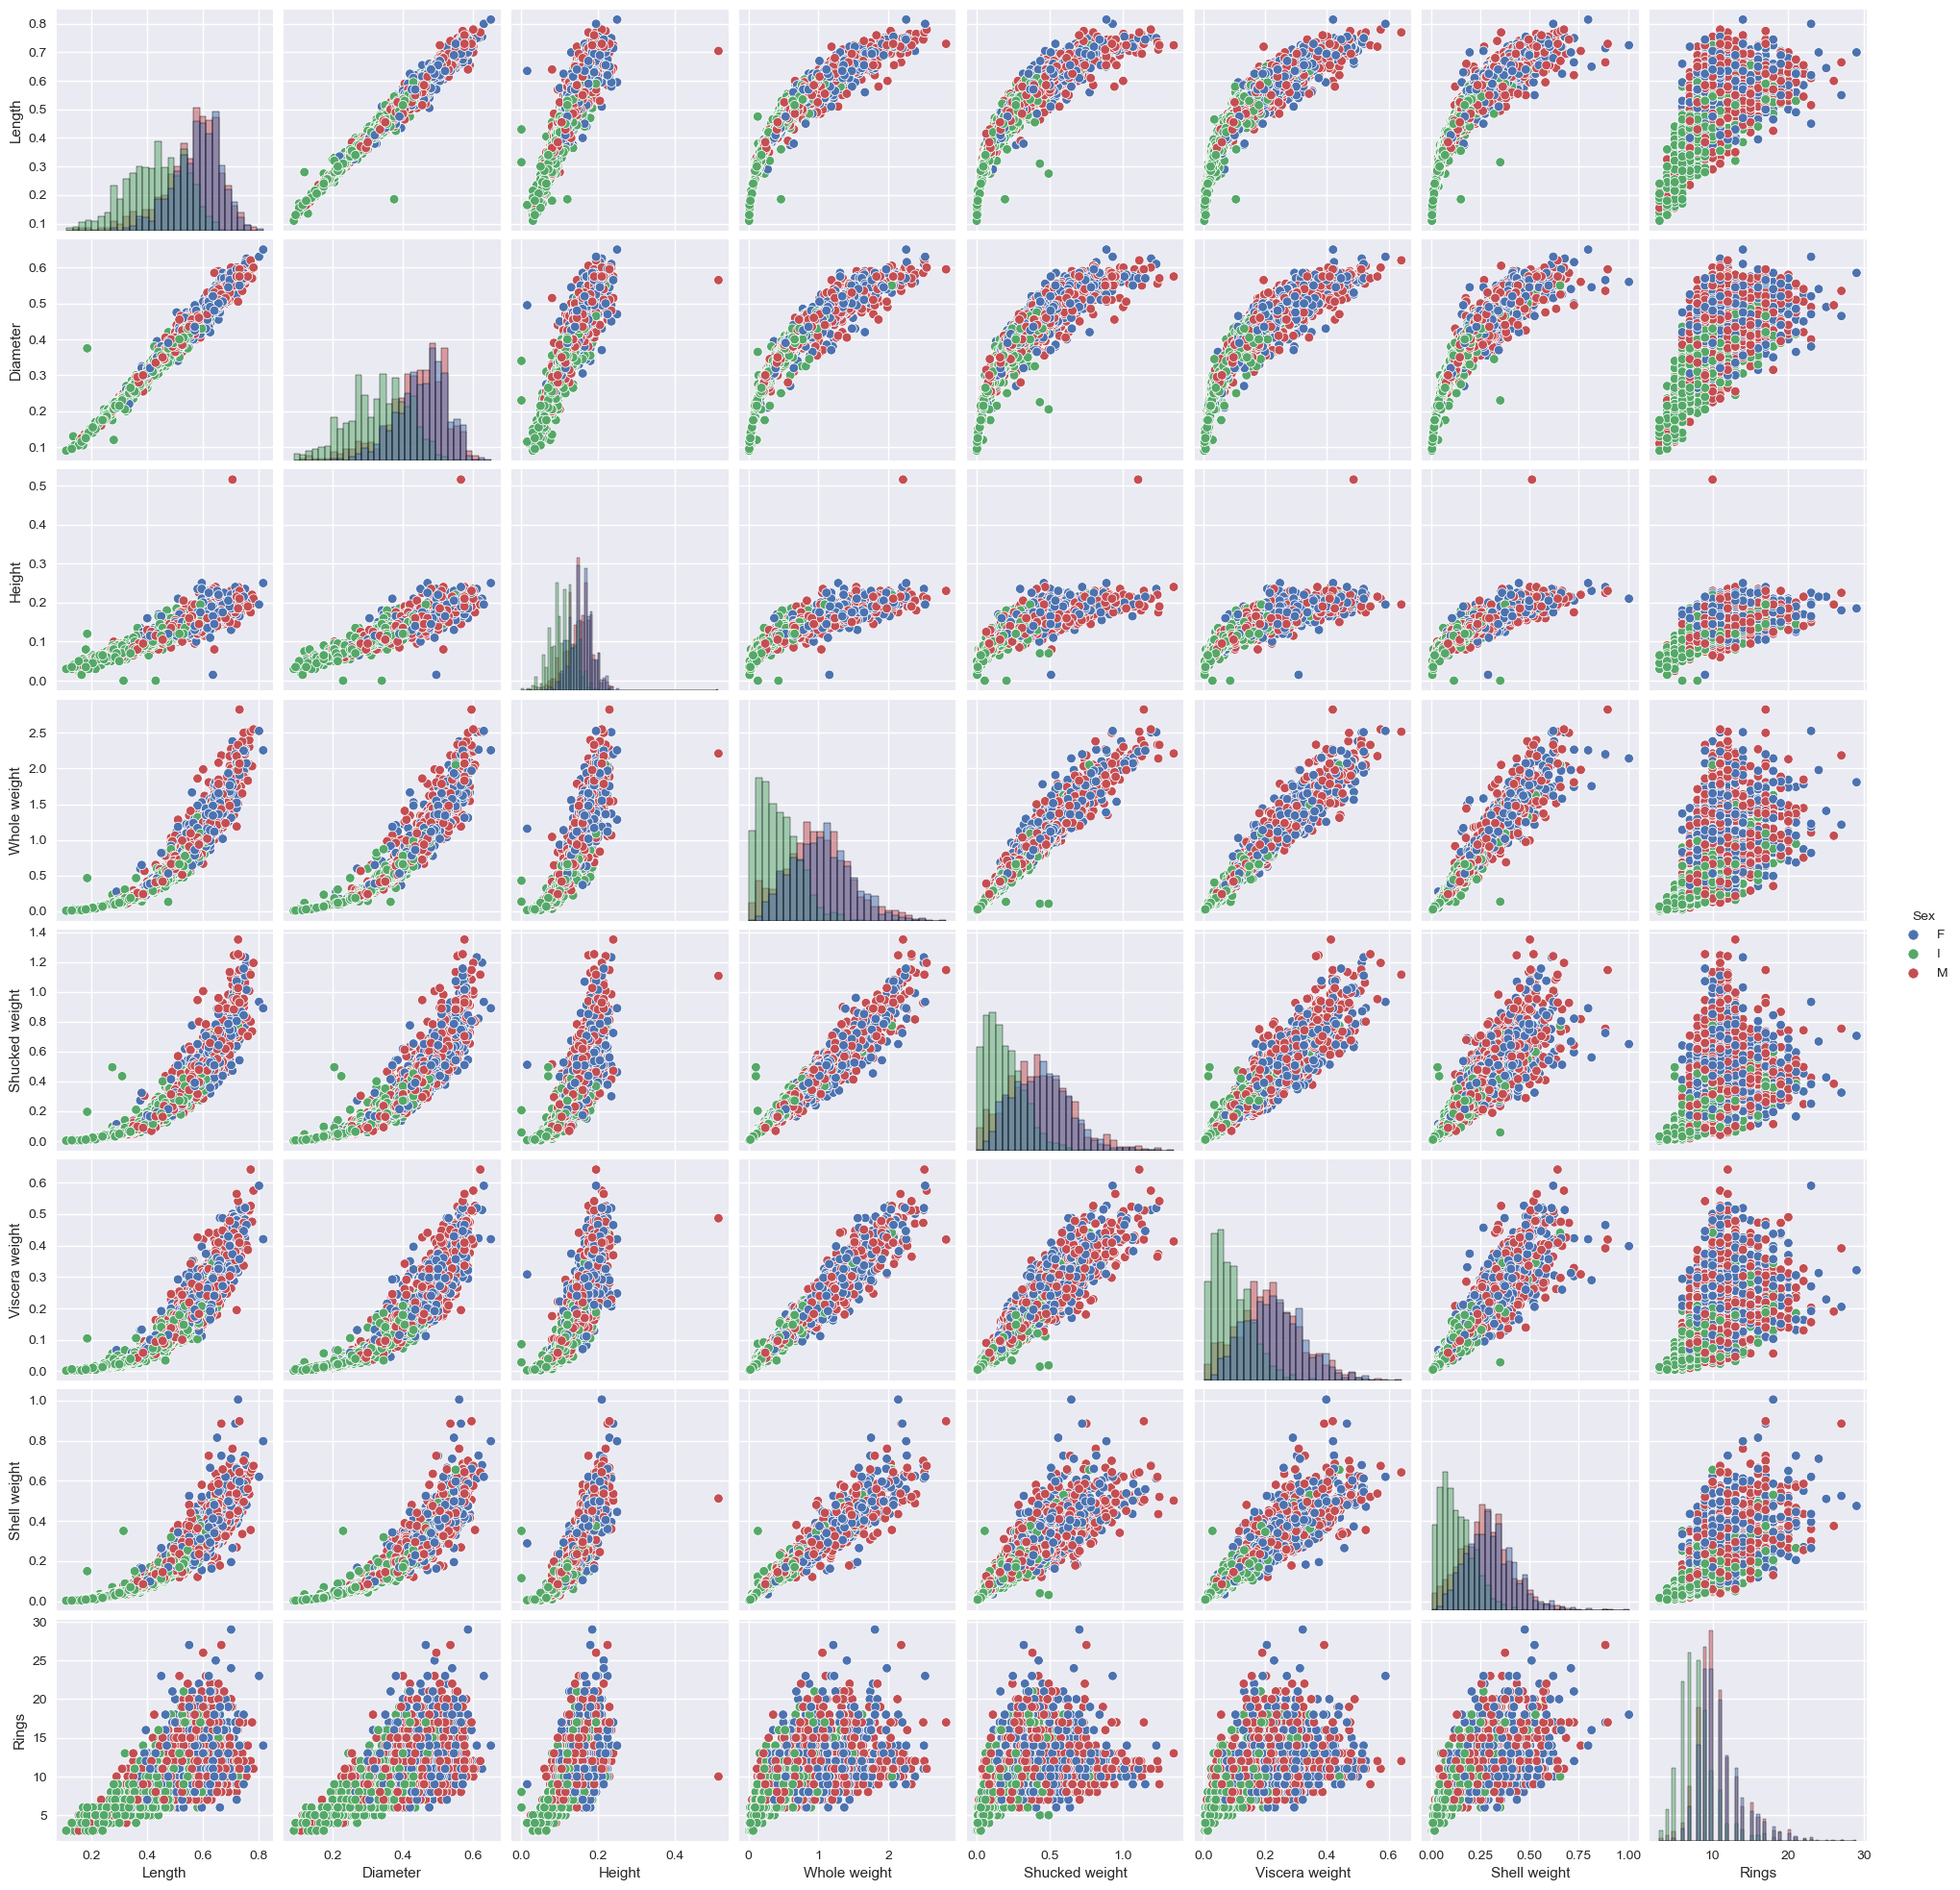

In [13]:
sns.pairplot(train, hue ='Sex', diag_kind='hist')
plt.show()

- The patterns are monotonically increasing, i.e., as the value of the physical measurment increases, so does the age of the abalone.
- There are strong linear, and quadratic dependecies.
- There are outliers.
- The infant abalone are concentrated at the begining of the scater plot, and as the physical measurment increases, the male and female abalone appear, and are relatively equally present, which is expected.

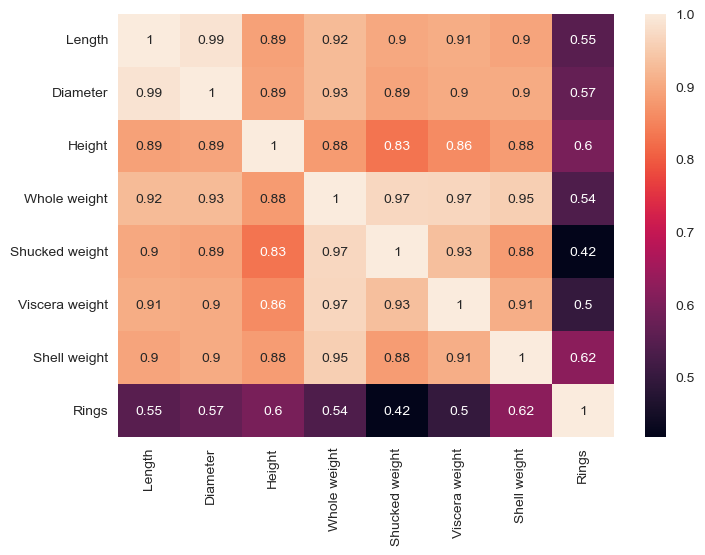

In [14]:
corr_matrix = train.corr()
sns.heatmap(corr_matrix, annot=True)
plt.show()

- We obsreve that there is weak linear relationship between each of the features and the target, so it is possible that linear models won't have a satisfactory performance. To fit a linear model the features that have the highest correlation with the target should be used.
- More robust models, i.e., models that predict reliably across samples drawn from the same distribution, are those that in which the features are highly correlated with the target, but are weakly correlated with each other. We shouldn't expect such performance here.
- We will use principal component analysis as a dimensionality reduction technique. It does so by creating new uncorrelated variables at the same time trying to lose as little information as possible.

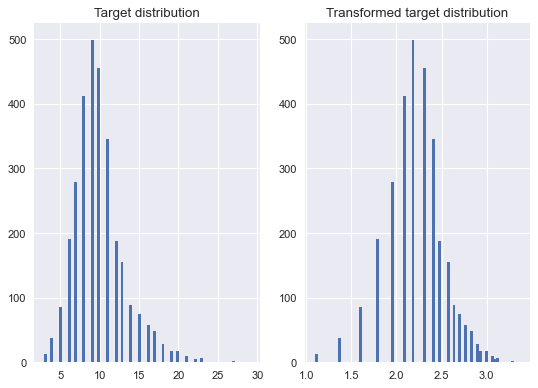

In [15]:
plt.figure(dpi=80)
plt.subplot(1,2,1)
plt.hist(train['Rings'], bins=70)
plt.title('Target distribution')

plt.subplot(1,2,2)
plt.hist(np.log(train['Rings']), bins=70)
plt.title('Transformed target distribution')
plt.show()

It turns out that it is benefitial to transform the target values in a regression problem because it aids the learning of the algorithms. A logarithmic function will be applied on the target `Rings` to linearize it.

## Data Preprocessing <a class="anchor" id="chapter5"></a>

In [16]:
def data_wrangling(df):
    # remove data points = 0.0
    return df[(df != 0).all(axis=1)]

In [17]:
train = data_wrangling(train)
val = data_wrangling(val)
test = data_wrangling(test)

In [18]:
numerical_transformer = Pipeline([
    ('standardization', StandardScaler()),
    ('pca', PCA()), # PCA for numerical data
])

preprocessor = ColumnTransformer([
    ('1hot', OneHotEncoder(), make_column_selector(dtype_include='object')), # one-hot encoding for categorical data
    ('num', numerical_transformer, make_column_selector(dtype_include='number'))
])

In [19]:
X_train, y_train = train.drop(columns=['Rings']), train['Rings']
X_val, y_val = val.drop(columns=['Rings']), val['Rings']
X_test, y_test = test.drop(columns=['Rings']), test['Rings']

In [20]:
X_train = preprocessor.fit_transform(X_train)
X_val = preprocessor.transform(X_val)
X_test = preprocessor.transform(X_test)

In [21]:
y_train = np.log(y_train).to_numpy()
y_val = np.log(y_val).to_numpy()
y_test = np.log(y_test).to_numpy()

## Models<a class="anchor" id="chapter6"></a>

In [22]:
def train_model(reg, X, y, lib='sklearn'):
    """
    Function to fit a regressor to the training data
    """
    print(f'Trainig of model: {reg.__class__.__name__}')

    if lib == 'sklearn':        
        reg.fit(X, y)

    elif lib == 'xgboost':        
        reg.fit(X, y,
                eval_set=[(X_val,y_val)], # outside defined
                verbose=10,
                )

    elif lib == 'tabnet':
        # define R2 metrics for TabNet
        class R2(Metric):
            def __init__(self):
                self._name = "r2"
                self._maximize = True

            def __call__(self, y_true, y_pred):
                return r2_score(y_true=y_true, y_pred=y_pred)
            
        reg.fit(X, y, 
                eval_set=[(X_val, y_val.reshape(-1, 1))], # outside variables
                eval_metric=[R2],
                batch_size=512, #1024
                )
    
    scores = cross_val_score(estimator=reg,
                            X=X,
                            y=y,
                            scoring='r2', # R2  is usually the best choice as a single evaluation metrics
                            cv=5,
                            n_jobs=-1)
    
    mean_score = np.mean(scores)
    std_score = np.std(scores)
    
    print(f'Parameters: {reg.get_params()}')
    print(f'CV R2 scores: {scores}')
    print(f'Cross-validated R2: {mean_score} +/- {std_score}')
    
    return mean_score

In [23]:
def randomized_search(reg, param_dist, X, y):
    '''
    Function to tune hyper-parameters of models with randomized search
    '''
    rnd_search = RandomizedSearchCV(estimator=reg,
                                    param_distributions=param_dist,
                                    n_iter=10,
                                    scoring='r2',
                                    n_jobs=-1,
                                    cv=5,
                                    random_state=1234).fit(X, y)

    print(f'Best estimator: {rnd_search.best_estimator_}')
    print(f'Best mean cross-validated score: {rnd_search.best_score_}')

    return rnd_search.best_estimator_, rnd_search.best_score_

### k-Nearest Neighbors<a class="anchor" id="section6_1"></a>

In [24]:
knn = KNeighborsRegressor(n_jobs=-1)

In [25]:
knn_score = train_model(reg=knn, X=X_train, y=y_train)

Trainig of model: KNeighborsRegressor
Parameters: {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': -1, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}
CV R2 scores: [0.55578352 0.59142787 0.5614214  0.53755016 0.61872567]
Cross-validated R2: 0.5729817245484138 +/- 0.028696983668931985


In [26]:
%%time

n_neighbors = [2, 3, 4, 5, 8, 16]
weights = ['uniform', 'distance']
p = [2, 3]

param_dist_knn = {'n_neighbors': n_neighbors,
                  'weights': weights,
                  'p': p
                  }

knn_best, knn_best_score = randomized_search(reg=knn, param_dist=param_dist_knn, X=X_train, y=y_train)

Best estimator: KNeighborsRegressor(n_jobs=-1, n_neighbors=8, p=3)
Best mean cross-validated score: 0.5956598932396708
Wall time: 1.7 s


### Support Vector Regressor <a class="anchor" id="section6_2"></a>

In [27]:
svr = SVR()

In [28]:
svr_score = train_model(reg=svr, X=X_train, y=y_train)

Trainig of model: SVR
Parameters: {'C': 1.0, 'cache_size': 200, 'coef0': 0.0, 'degree': 3, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'shrinking': True, 'tol': 0.001, 'verbose': False}
CV R2 scores: [0.6337966  0.64631639 0.65681831 0.63886853 0.67974799]
Cross-validated R2: 0.6511095620560023 +/- 0.016280699235957066


In [29]:
%%time

C = [0.001, 0.01, 0.1, 1, 10, 100, 1000] # np.logspace(-3, 3, 7)
# kernel = ['linear', 'poly', 'rbf', 'sigmoid'] # 'precomputed' is removed, via https://stackoverflow.com/questions/36306555/scikit-learn-grid-search-with-svm-regression
# degree = [2, 3, 4]
gamma = ['scale', 'auto'] # a coefficient for 'rbf', 'poly', and 'sigmoid'
gamma.extend(np.logspace(-3, 3, 7))

param_dist_svr = {'C': C,
                  # 'kernel': kernel,
                  # 'degree': degree, # works only with poly kernel
                  'gamma': gamma,
                  }

svr_best, svr_best_score = randomized_search(reg=svr, param_dist=param_dist_svr, X=X_train, y=y_train)

Best estimator: SVR(C=1, gamma=0.1)
Best mean cross-validated score: 0.6522104244191834
Wall time: 31.1 s


### Random Forests<a class="anchor" id="section6_3"></a>

In [30]:
rf = RandomForestRegressor(n_jobs=-1, random_state=1234)

In [31]:
rf_score = train_model(reg=rf, X=X_train, y=y_train)

Trainig of model: RandomForestRegressor
Parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': False, 'random_state': 1234, 'verbose': 0, 'warm_start': False}
CV R2 scores: [0.60951664 0.64153647 0.62975802 0.63341012 0.67831488]
Cross-validated R2: 0.638507225673888 +/- 0.02252469302659743


In [32]:
%%time

n_estimators = [100, 120, 300, 500, 800, 1200]
max_depth = [5, 8, 15, 25, 30, None]
min_samples_leaf = [1, 2, 5, 10]
bootstrap = [True, False]
max_features = [1, 2, 5, 'log2', 'sqrt', None]
    
param_dist_rf = {'n_estimators': n_estimators,
                 'max_depth': max_depth,
                 'min_samples_leaf': min_samples_leaf,
                 'bootstrap': bootstrap,
                 'max_features': max_features,
                 }

rf_best, rf_best_score = randomized_search(reg=rf, param_dist=param_dist_rf, X=X_train, y=y_train)

Best estimator: RandomForestRegressor(max_depth=30, max_features='log2', min_samples_leaf=5,
                      n_estimators=800, n_jobs=-1, random_state=1234)
Best mean cross-validated score: 0.6446340731365774
Wall time: 47.9 s


### XGBoost <a class="anchor" id="section6_4"></a>

In [33]:
xgb_reg = XGBRegressor(objective ='reg:squarederror')

In [34]:
xgb_score = train_model(reg=xgb_reg, X=X_train, y=y_train, lib='xgboost')

Trainig of model: XGBRegressor
[0]	validation_0-rmse:1.24417
[10]	validation_0-rmse:0.18287
[20]	validation_0-rmse:0.17982
[30]	validation_0-rmse:0.18094
[40]	validation_0-rmse:0.18362
[50]	validation_0-rmse:0.18512
[60]	validation_0-rmse:0.18500
[70]	validation_0-rmse:0.18472
[80]	validation_0-rmse:0.18459
[90]	validation_0-rmse:0.18547
[99]	validation_0-rmse:0.18692
Parameters: {'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'gpu_id': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'n_es

In [37]:
%%time

n_estimators = [1000, 3000, 5000]
learning_rate = [0.01, 0.03, 0.1, 0.3, 1]
max_depth = [1, 4, 5, 7, 10]
gamma = np.logspace(-9, 0, 10)
subsample = [0.1, 0.2, 0.5, 0.8, 1.0]
colsample_bytree = [0.1, 0.2, 0.5, 0.8, 1.0]
colsample_bylevel = [0.1, 0.2, 0.5, 0.8, 1.0]

param_dist_xgb = {'n_estimators': n_estimators,
                  'learning_rate': learning_rate,
                  'max_depth': max_depth,
                  'gamma': max_depth,
                  'subsample': subsample,
                  'colsample_bytree': colsample_bytree,
                  'colsample_bylevel': colsample_bylevel,
                  }

xgb_best, xgb_best_score = randomized_search(reg=xgb_reg, param_dist=param_dist_xgb, X=X_train, y=y_train)

Best estimator: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.2, colsample_bynode=None, colsample_bytree=1.0,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=1, gpu_id=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=3000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)
Best mean cross-validated score: 0.6248208613581054
Wall time: 1min 14s


### TabNet <a class="anchor" id="section6_5"></a>

In [38]:
tb_reg = TabNetRegressor()

In [39]:
tb_score = train_model(reg=tb_reg, X=X_train, y=y_train.reshape(-1,1), lib='tabnet') # change shape of target for TabNet

Trainig of model: TabNetRegressor
epoch 0  | loss: 1.63785 | val_0_r2: -10.09909|  0:00:00s
epoch 1  | loss: 0.3484  | val_0_r2: -5.2478 |  0:00:00s
epoch 2  | loss: 0.19347 | val_0_r2: -1.63798|  0:00:01s
epoch 3  | loss: 0.13312 | val_0_r2: -0.21854|  0:00:01s
epoch 4  | loss: 0.10167 | val_0_r2: 0.04374 |  0:00:01s
epoch 5  | loss: 0.09053 | val_0_r2: 0.24213 |  0:00:02s
epoch 6  | loss: 0.07498 | val_0_r2: 0.36246 |  0:00:02s
epoch 7  | loss: 0.07028 | val_0_r2: 0.34351 |  0:00:03s
epoch 8  | loss: 0.06598 | val_0_r2: 0.22964 |  0:00:03s
epoch 9  | loss: 0.06094 | val_0_r2: 0.50701 |  0:00:03s
epoch 10 | loss: 0.06115 | val_0_r2: 0.5381  |  0:00:04s
epoch 11 | loss: 0.05508 | val_0_r2: 0.48318 |  0:00:04s
epoch 12 | loss: 0.05477 | val_0_r2: 0.5098  |  0:00:04s
epoch 13 | loss: 0.05539 | val_0_r2: 0.55324 |  0:00:05s
epoch 14 | loss: 0.05382 | val_0_r2: 0.44383 |  0:00:05s
epoch 15 | loss: 0.05628 | val_0_r2: 0.54528 |  0:00:05s
epoch 16 | loss: 0.05373 | val_0_r2: 0.55905 |  0:00:

In [40]:
%%time

n_d = n_a = [8, 16, 32, 64]
n_steps = [3, 6, 10]
gamma = [1.0, 1.3, 1.7, 2.0]

param_dist_tb = {'n_d': n_d,
                 'n_a': n_a,
                 'n_steps': n_steps,
                 'gamma': gamma,
                 }

tb_best, tb_best_score = randomized_search(reg=tb_reg, param_dist=param_dist_tb, X=X_train, y=y_train.reshape(-1,1))

epoch 0  | loss: 28.81594|  0:00:00s
epoch 1  | loss: 4.83037 |  0:00:01s
epoch 2  | loss: 1.12146 |  0:00:01s
epoch 3  | loss: 0.77138 |  0:00:02s
epoch 4  | loss: 0.34765 |  0:00:03s
epoch 5  | loss: 0.25112 |  0:00:04s
epoch 6  | loss: 0.17914 |  0:00:04s
epoch 7  | loss: 0.15692 |  0:00:05s
epoch 8  | loss: 0.11604 |  0:00:06s
epoch 9  | loss: 0.10412 |  0:00:06s
epoch 10 | loss: 0.09341 |  0:00:07s
epoch 11 | loss: 0.08226 |  0:00:08s
epoch 12 | loss: 0.08001 |  0:00:08s
epoch 13 | loss: 0.07312 |  0:00:09s
epoch 14 | loss: 0.06718 |  0:00:10s
epoch 15 | loss: 0.0631  |  0:00:10s
epoch 16 | loss: 0.06052 |  0:00:11s
epoch 17 | loss: 0.05461 |  0:00:12s
epoch 18 | loss: 0.05314 |  0:00:12s
epoch 19 | loss: 0.05078 |  0:00:13s
epoch 20 | loss: 0.05056 |  0:00:14s
epoch 21 | loss: 0.05116 |  0:00:14s
epoch 22 | loss: 0.05158 |  0:00:15s
epoch 23 | loss: 0.04789 |  0:00:16s
epoch 24 | loss: 0.04731 |  0:00:16s
epoch 25 | loss: 0.04472 |  0:00:17s
epoch 26 | loss: 0.04831 |  0:00:18s
e

## Model Evaluation<a class="anchor" id="chapter7"></a>

In [41]:
models = [knn_best, svr_best, rf_best, xgb_best, tb_best]
labels = ['knn', 'svr', 'rf', 'xgb_reg', 'tb_reg']

r2_scores = []
mae_scores = []

In [42]:
for reg, label in zip(models, labels):
    y_pred = reg.predict(X_test)

    r2_reg = r2_score(y_test, y_pred)
    r2_scores.append(r2_reg)

    mae_reg = mean_absolute_error(y_test, y_pred)
    mae_scores.append(mae_reg)

In [43]:
scoring_summary = pd.DataFrame({'Model': labels, 'R2': r2_scores, 'MAE': mae_reg})
scoring_summary = scoring_summary.sort_values('R2', ascending=False)

In [44]:
scoring_summary

,Model,R2,MAE
1,svr,0.648345,0.150959
2,rf,0.645901,0.150959
3,xgb_reg,0.633359,0.150959
0,knn,0.586647,0.150959
4,tb_reg,0.580247,0.150959


The most optimal model for our application is Support Vector Regressor with $R^2=0.648345$.

## Bibliography <a class="anchor" id="chapter8"></a>
- [1] P. Steyn, “Poaching for Abalone, Africa’s ‘White Gold,’ Reaches Fever Pitch,” National Geographic, Feb. 14, 2017. https://www.nationalgeographic.com/animals/article/wildlife-watch-abalone-poaching-south-africa (accessed Jul. 21, 2020).
- [2] M. Hossain and N. M. Chowdhury, “Econometric Ways to Estimate the Age and Price of Abalone,” mpra.ub.uni-muenchen.de, Jan. 03, 2019. https://mpra.ub.uni-muenchen.de/91210/ (accessed Jul. 21, 2020).
- [3] Abalone. (1995). UCI Machine Learning Repository.
- [4] F. J. Rohlf and F. L. Bookstein, Proceedings of the Michigan Morphometrics Workshop. University of Michigan Museum of Zoology, 1990, pp. 77–122.